<a href="https://colab.research.google.com/github/Cheryleen5/Hate_Speech_Detection/blob/main/FINAL_HATESPEECH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/A.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [ ]:
df.shape

(726119, 2)

In [ ]:
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [ ]:
# Extract features and labels
x = df['Content']
y = df['Label']

# Ensure no NaN values after mapping
y = y.fillna(0).astype(int)

# Tokenization
max_features = 20000  # Vocabulary size
max_text_length = 400  # Max length of each comment

x_tokenizer = Tokenizer(num_words=max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_padded = pad_sequences(x_tokenized, maxlen=max_text_length)

Epoch 1/10
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 120s 14ms/step - accuracy: 0.7719 - loss: 0.4657 - val_accuracy: 0.8257 - val_loss: 0.3752
Epoch 2/10
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 113s 14ms/step - accuracy: 0.8255 - loss: 0.3787 - val_accuracy: 0.8359 - val_loss: 0.3628
Epoch 3/10
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.8383 - loss: 0.3540 - val_accuracy: 0.8456 - val_loss: 0.3407
Epoch 4/10
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - accuracy: 0.8467 - loss: 0.3375 - val_accuracy: 0.8484 - val_loss: 0.3362
Epoch 5/10
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 112s 14ms/step - accuracy: 0.8535 - loss: 0.3243 - val_accuracy: 0.8463 - val_loss: 0.3471
Epoch 6/10
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 143s 14ms/step - accuracy: 0.8592 - loss: 0.3128 - val_accuracy: 0.8531 - val_loss: 0.3285
Epoch 7/10
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - accuracy: 0.8640 - loss: 0.3036 - val_accuracy: 0.8522 - val_loss: 0.3312
Epoch 8/10
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 112s 14ms/step - accuracy: 

6808/6808 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


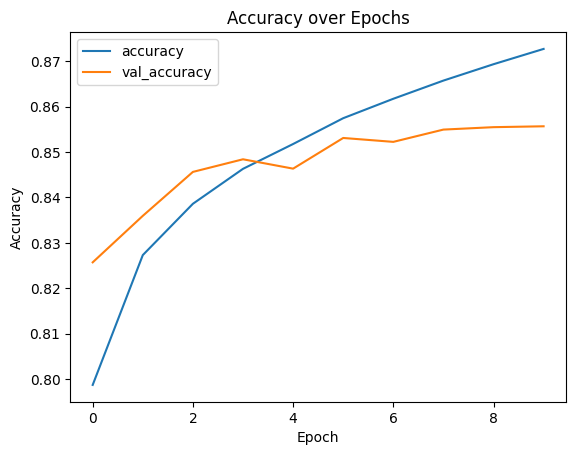

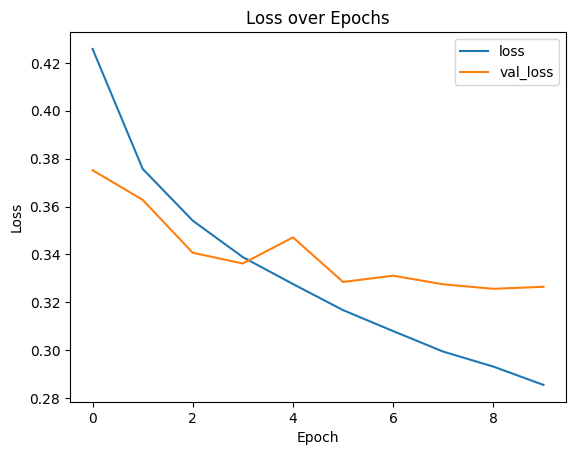

In [ ]:
# 10 EPOCHS

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_padded, y, test_size=0.3, random_state=1)

# Load pre-trained GloVe embeddings
embedding_dim = 100
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Build CNN model
filters = 250
kernel_size = 3
hidden_dims = 250

model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 10
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val))

# Save the model
model.save('/content/drive/MyDrive/hate_speech_model.h5')
# Evaluation
y_val_pred_prob = model.predict(x_val)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

# Plotting Accuracy and Loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 400, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 400, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 398, 250)            │          75,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 199, 250)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 195, 250)            │         312,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 250)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,451,003 (9.35 MB)

 Trainable params: 451,001 (1.72 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 2 (12.00 B)

6808/6808 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8559 - loss: 0.3267
Overall validation accuracy: 85.57%
6808/6808 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


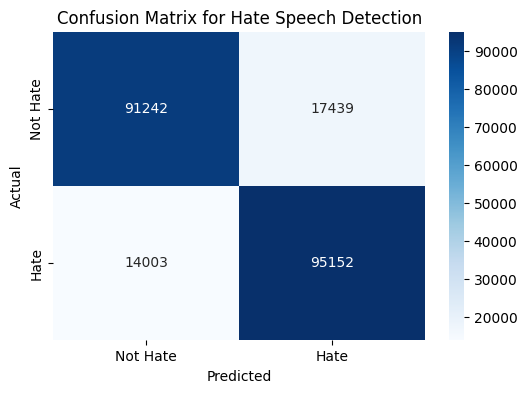

              precision    recall  f1-score   support

    Not Hate       0.87      0.84      0.85    108681
        Hate       0.85      0.87      0.86    109155

    accuracy                           0.86    217836
   macro avg       0.86      0.86      0.86    217836
weighted avg       0.86      0.86      0.86    217836



In [ ]:
# Load the saved model
model = load_model('/content/drive/MyDrive/hate_speech_model.h5')
model.summary()
# Assuming x_val and y_val are already defined and preprocessed
# Evaluate the loaded model
val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=1)

# Print overall accuracy
print(f"Overall validation accuracy: {val_accuracy * 100:.2f}%")

# Make predictions on validation data
y_val_pred_prob = model.predict(x_val)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hate', 'Hate'], yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hate Speech Detection')
plt.show()

# Optional: print classification report for more details
print(classification_report(y_val, y_val_pred, target_names=['Not Hate', 'Hate']))

In [ ]:
# New sentences to check (some hate, some non-hate)
new_sentences = [
"I can't believe how amazing the community has become. Everyone is so supportive!",
"This group of people doesn't deserve any respect. They're ruining everything.",
"I love the way people are coming together to help each other!",
"You don't belong here. Why don't you just leave and never come back?",
"Helping others is what makes the world a better place.",
"These idiots should be banned from everywhere. They are a disgrace.",
"It’s inspiring to see people from all backgrounds working together for a good cause.",
"You're nothing but a loser, and no one cares about you!",
"Let’s keep spreading kindness and understanding, that’s what the world needs.",
"All they ever do is complain and whine. Just get rid of them already."
]

# Tokenize the new sentences using the tokenizer created earlier
new_sentences_tokenized = x_tokenizer.texts_to_sequences(new_sentences)

# Pad the sequences to the same length as the training data
new_sentences_padded = pad_sequences(new_sentences_tokenized, maxlen=max_text_length)

# Use the trained model to make predictions
new_predictions_prob = model.predict(new_sentences_padded)

# Convert predictions to binary classes (0 = not hate, 1 = hate) based on a threshold (0.85)
new_predictions = (new_predictions_prob >= 0.5).astype(int)

# Print the predictions
for i, sentence in enumerate(new_sentences):
    prediction = "Hate" if new_predictions[i] == 1 else "Not Hate"
    print(f"Sentence: '{sentence}' --> Prediction: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Sentence: 'I can't believe how amazing the community has become. Everyone is so supportive!' --> Prediction: Not Hate
Sentence: 'This group of people doesn't deserve any respect. They're ruining everything.' --> Prediction: Hate
Sentence: 'I love the way people are coming together to help each other!' --> Prediction: Not Hate
Sentence: 'You don't belong here. Why don't you just leave and never come back?' --> Prediction: Hate
Sentence: 'Helping others is what makes the world a better place.' --> Prediction: Not Hate
Sentence: 'These idiots should be banned from everywhere. They are a disgrace.' --> Prediction: Hate
Sentence: 'It’s inspiring to see people from all backgrounds working together for a good cause.' --> Prediction: Not Hate
Sentence: 'You're nothing but a loser, and no one cares about you!' --> Prediction: Hate
Sentence: 'Let’s keep spreading kindness and understanding, that’s what the world needs.' --> Prediction: Not Hate
Sentence: 'A

Epoch 1/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 127s 15ms/step - accuracy: 0.7751 - loss: 0.4627 - val_accuracy: 0.8302 - val_loss: 0.3714
Epoch 2/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 126s 14ms/step - accuracy: 0.8254 - loss: 0.3779 - val_accuracy: 0.8393 - val_loss: 0.3512
Epoch 3/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 145s 14ms/step - accuracy: 0.8386 - loss: 0.3544 - val_accuracy: 0.8420 - val_loss: 0.3455
Epoch 4/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 119s 15ms/step - accuracy: 0.8476 - loss: 0.3365 - val_accuracy: 0.8463 - val_loss: 0.3378
Epoch 5/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 110s 14ms/step - accuracy: 0.8537 - loss: 0.3237 - val_accuracy: 0.8513 - val_loss: 0.3287
Epoch 6/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 151s 15ms/step - accuracy: 0.8593 - loss: 0.3119 - val_accuracy: 0.8510 - val_loss: 0.3290
Epoch 7/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - accuracy: 0.8649 - loss: 0.3005 - val_accuracy: 0.8537 - val_loss: 0.3291
Epoch 8/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 111s 14ms/step - accuracy: 

6808/6808 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


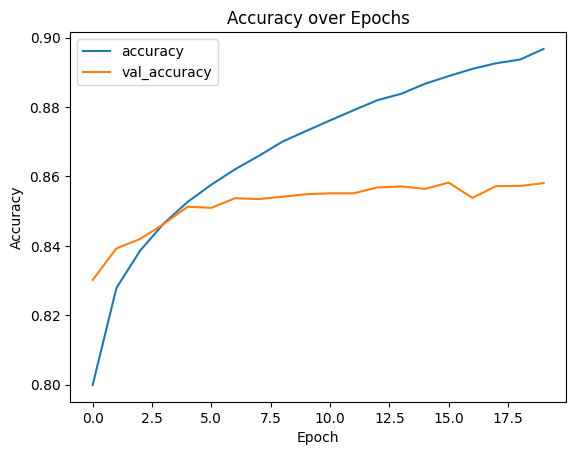

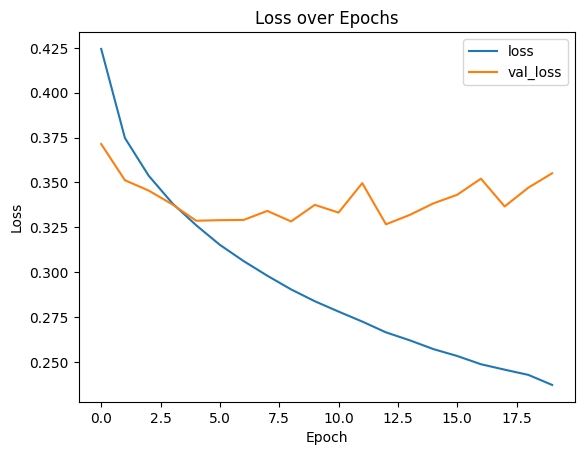

In [ ]:
# 20 EPOCHS

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_padded, y, test_size=0.3, random_state=1)

# Load pre-trained GloVe embeddings
embedding_dim = 100
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Build CNN model
filters = 250
kernel_size = 3
hidden_dims = 250

model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 20
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val))

# Save the model
model.save('/content/drive/MyDrive/hate_speech_model_20.h5')

# Evaluation
y_val_pred_prob = model.predict(x_val)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

# Plotting Accuracy and Loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 400, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 400, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 398, 250)            │          75,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 199, 250)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 195, 250)            │         312,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 250)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,451,003 (9.35 MB)

 Trainable params: 451,001 (1.72 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 2 (12.00 B)

6808/6808 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8584 - loss: 0.3544
Overall validation accuracy: 85.81%
6808/6808 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


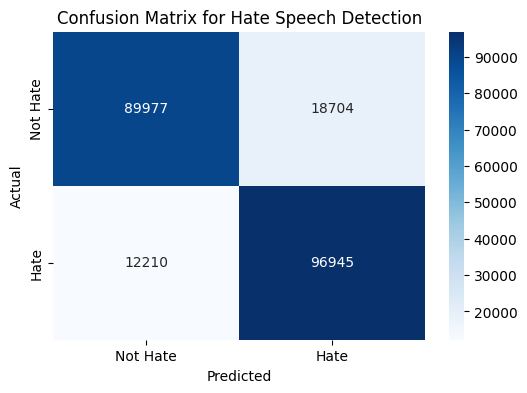

              precision    recall  f1-score   support

    Not Hate       0.88      0.83      0.85    108681
        Hate       0.84      0.89      0.86    109155

    accuracy                           0.86    217836
   macro avg       0.86      0.86      0.86    217836
weighted avg       0.86      0.86      0.86    217836



In [ ]:
# Load the saved model
model = load_model('/content/drive/MyDrive/hate_speech_model_20.h5')
model.summary()
# Assuming x_val and y_val are already defined and preprocessed
# Evaluate the loaded model
val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=1)

# Print overall accuracy
print(f"Overall validation accuracy: {val_accuracy * 100:.2f}%")

# Make predictions on validation data
y_val_pred_prob = model.predict(x_val)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hate', 'Hate'], yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hate Speech Detection')
plt.show()

# Optional: print classification report for more details
print(classification_report(y_val, y_val_pred, target_names=['Not Hate', 'Hate']))

Epoch 1/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 126s 15ms/step - accuracy: 0.7757 - loss: 0.4611 - val_accuracy: 0.8311 - val_loss: 0.3686
Epoch 2/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 139s 15ms/step - accuracy: 0.8272 - loss: 0.3756 - val_accuracy: 0.8399 - val_loss: 0.3504
Epoch 3/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - accuracy: 0.8391 - loss: 0.3534 - val_accuracy: 0.8459 - val_loss: 0.3393
Epoch 4/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - accuracy: 0.8464 - loss: 0.3374 - val_accuracy: 0.8465 - val_loss: 0.3399
Epoch 5/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 144s 16ms/step - accuracy: 0.8533 - loss: 0.3235 - val_accuracy: 0.8486 - val_loss: 0.3343
Epoch 6/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 133s 14ms/step - accuracy: 0.8594 - loss: 0.3118 - val_accuracy: 0.8501 - val_loss: 0.3393
Epoch 7/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 123s 15ms/step - accuracy: 0.8637 - loss: 0.3036 - val_accuracy: 0.8516 - val_loss: 0.3272
Epoch 8/20
7942/7942 ━━━━━━━━━━━━━━━━━━━━ 133s 14ms/step - accuracy: 

6808/6808 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


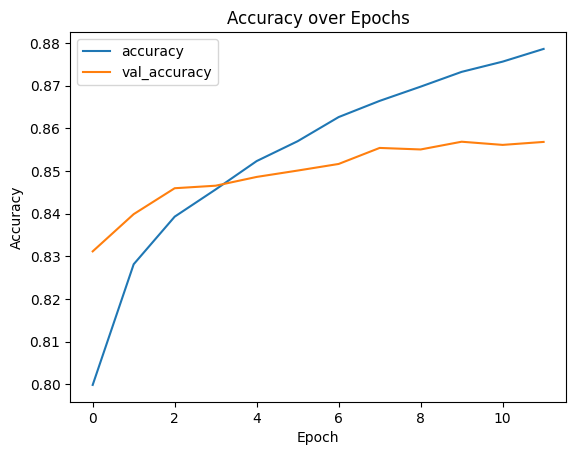

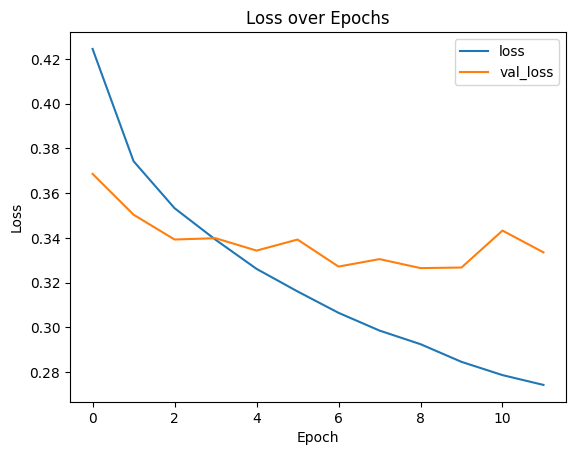

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_padded, y, test_size=0.3, random_state=1)

# Load pre-trained GloVe embeddings
embedding_dim = 100
embeddings_index = {}
f = open('/content/drive/MyDrive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

# Create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

# Build CNN model
filters = 250
kernel_size = 3
hidden_dims = 250

model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, 5, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to determine early stopping
    patience=3,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
)

# Train the model with early stopping
batch_size = 64
epochs = 20
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

# Save the model
model.save('/content/drive/MyDrive/hate_speech_model_early.h5')

# Evaluation
y_val_pred_prob = model.predict(x_val)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

# Plotting Accuracy and Loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 400, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 400, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 398, 250)            │          75,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 199, 250)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 195, 250)            │         312,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 250)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             251 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,451,003 (9.35 MB)

 Trainable params: 451,001 (1.72 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

 Optimizer params: 2 (12.00 B)

6808/6808 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8556 - loss: 0.3241
Overall validation accuracy: 85.50%
6808/6808 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


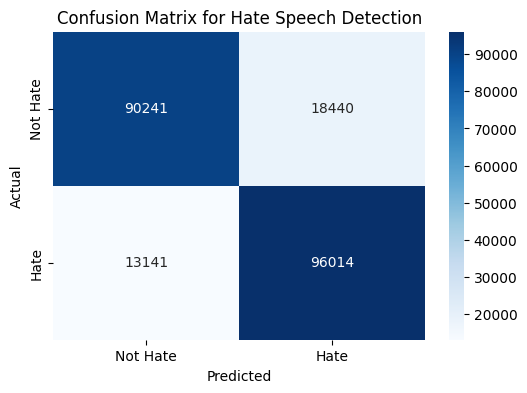

              precision    recall  f1-score   support

    Not Hate       0.87      0.83      0.85    108681
        Hate       0.84      0.88      0.86    109155

    accuracy                           0.86    217836
   macro avg       0.86      0.85      0.85    217836
weighted avg       0.86      0.86      0.85    217836



In [ ]:
# Load the saved model
model = load_model('/content/drive/MyDrive/hate_speech_model_early.h5')
model.summary()
# Assuming x_val and y_val are already defined and preprocessed
# Evaluate the loaded model
val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=1)

# Print overall accuracy
print(f"Overall validation accuracy: {val_accuracy * 100:.2f}%")

# Make predictions on validation data
y_val_pred_prob = model.predict(x_val)
y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hate', 'Hate'], yticklabels=['Not Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hate Speech Detection')
plt.show()

# Optional: print classification report for more details
print(classification_report(y_val, y_val_pred, target_names=['Not Hate', 'Hate']))

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the pre-trained model (e.g., the early stopping model)
model = load_model('/content/drive/MyDrive/hate_speech_model_early.h5')

# New sentences to check (some hate, some non-hate)
new_sentences = [
    # Hate speech sentences
    "You're a worthless piece of trash, nobody cares about your opinion.",
    "I hope you fail miserably, you're an embarrassment to everyone.",
    "You're so stupid, just shut up already.",
    "The world would be better off without idiots like you.",
    "Go f*** yourself, no one wants to hear your nonsense.",
    "I hate everything about you, you're just a pathetic loser.",
    "Nobody gives a damn about your pathetic existence.",
    "You're a waste of space, and it's better if you disappear.",
    "You disgust me, and I can't stand looking at you.",
    "You’re a piece of garbage, and everyone hates you.",

    # Non-hate speech sentences
    "It's amazing how much kindness is spreading in this community!",
    "I'm really proud of how far we've come together as a team.",
    "This event has brought so much joy to everyone, I'm grateful.",
    "Let's continue to support one another and make this world a better place.",
    "I truly appreciate all the hard work and dedication from everyone.",
    "It’s inspiring to see how people are coming together to help each other.",
    "I love the positive atmosphere here, everyone is so welcoming.",
    "We can make a real difference by spreading kindness and understanding.",
    "I'm grateful for all the love and support in this group.",
    "Seeing people help each other out really restores my faith in humanity."
]
# Tokenize the new sentences using the tokenizer created earlier
new_sentences_tokenized = x_tokenizer.texts_to_sequences(new_sentences)

# Pad the sequences to the same length as the training data
new_sentences_padded = pad_sequences(new_sentences_tokenized, maxlen=max_text_length)

# Use the trained model to make predictions
new_predictions_prob = model.predict(new_sentences_padded)

# Convert predictions to binary classes (0 = not hate, 1 = hate) based on a threshold (0.5)
new_predictions = (new_predictions_prob >= 0.5).astype(int)

# Print the predictions
for i, sentence in enumerate(new_sentences):
    prediction = "Hate" if new_predictions[i] == 1 else "Not Hate"
    print(f"Sentence: '{sentence}' --> Prediction: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Sentence: 'You're a worthless piece of trash, nobody cares about your opinion.' --> Prediction: Hate
Sentence: 'I hope you fail miserably, you're an embarrassment to everyone.' --> Prediction: Hate
Sentence: 'You're so stupid, just shut up already.' --> Prediction: Hate
Sentence: 'The world would be better off without idiots like you.' --> Prediction: Hate
Sentence: 'Go f*** yourself, no one wants to hear your nonsense.' --> Prediction: Hate
Sentence: 'I hate everything about you, you're just a pathetic loser.' --> Prediction: Hate
Sentence: 'Nobody gives a damn about your pathetic existence.' --> Prediction: Hate
Sentence: 'You're a waste of space, and it's better if you disappear.' --> Prediction: Hate
Sentence: 'You disgust me, and I can't stand looking at you.' --> Prediction: Hate
Sentence: 'You’re a piece of garbage, and everyone hates you.' --> Prediction: Hate
Sentence: 'It's amazing how much kindness is spreading in this community!' --> P